#### Get an ODBC connection 

In [153]:
import pyodbc 
import time

server = 'irisimlsvr'
port = '1972'
database = 'USER' 
username = 'SUPERUSER' 
password = 'SYS' 
cnxn = pyodbc.connect('DRIVER={InterSystems ODBC35};SERVER='+server+';PORT='+port+';DATABASE='+database+';UID='+username+';PWD='+ password)

cnxn.setdecoding(pyodbc.SQL_CHAR, encoding='utf8')
cnxn.setdecoding(pyodbc.SQL_WCHAR, encoding='utf8')
cnxn.setencoding(encoding='utf8')
cursor = cnxn.cursor()
print('Connection created')

Connection created


####  Prepare training data, and give a model name

In [143]:
currency = {
    'bitcoin': 1,
    'ethereum': 1027,
    'tether': 825,
    'dogecoin': 74
}
selected_currency = "bitcoin" # SET YOUR CRYPTOCURRENCY HERE (bitcoin, ethereum, tether, dogecoin)

dataTable = 'BitcoinRates_'+selected_currency
dataColumn =  'Rate'
dataColumnPredict = "PredictedRate"
modelName = "SVR_model_"+selected_currency # must be unique
train_size=90 #days
test_size=10

#### Get history rates

In [144]:
cursor.execute(f"CREATE TABLE {dataTable} ( id INT(32) AUTO_INCREMENT PRIMARY KEY, day DATE, rate FLOAT)")

In [155]:
import pandas as pd
from datetime import datetime, timedelta
import requests

last_year_rates = pd.DataFrame(columns=['Date', 'Rate'])

time_start = int((datetime.today() - timedelta(days=100)).timestamp())
time_end = int(datetime.today().timestamp())

url = f'https://api.coinmarketcap.com/data-api/v3/cryptocurrency/historical?id={currency[selected_currency]}&convertId=2781&timeStart={time_start}&timeEnd={time_end}'
resp = requests.get(url=url)
data = resp.json()
for item in data['data']['quotes']:
    last_year_rates = last_year_rates.append({'Date': item['timeOpen'][:10], 'Rate': (item['quote']['high']+item['quote']['low'])/2}, ignore_index=True)
last_year_rates = last_year_rates.reset_index()
last_year_rates.tail()

,index,Date,Rate
94,94,2022-05-27,28836.778337
95,95,2022-05-28,28845.242139
96,96,2022-05-29,29169.557664
97,97,2022-05-30,30626.601626
98,98,2022-05-31,31768.009140


#### Draw a chart of the cryptocurrency rate 

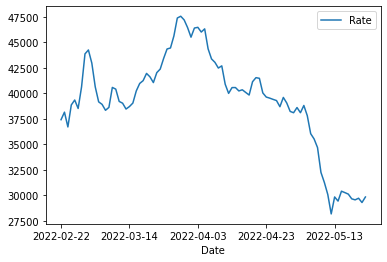

In [146]:
last_year_rates[:train_size].plot.line('Date', 'Rate')

#### Insert data into IRIS

In [147]:
cursor.execute(f"TRUNCATE TABLE {dataTable}")
for index, row in last_year_rates.iterrows():
    cursor.execute(f"INSERT INTO {dataTable} (day, rate) VALUES ('{str(row['Date'])}', {row['Rate']})")
cnxn.commit()

print('Values inserted')

Values inserted


#### Train model and make prediction

In [148]:
cursor.execute("CREATE MODEL %s PREDICTING (%s)  FROM %s" % (modelName, dataColumn, dataTable))

cursor.execute("TRAIN MODEL %s FROM %s" % (modelName, dataTable))
cnxn.commit()
print('Model training completed')

Model training completed


#### Look at the result

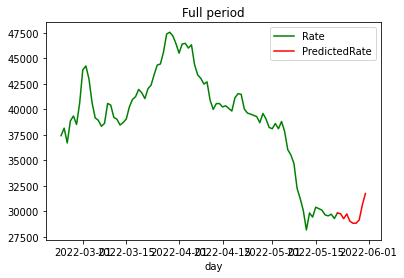

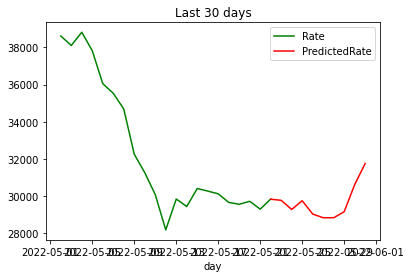

In [149]:
data = pd.read_sql("SELECT %s as Rate, day FROM %s" % (dataColumn, dataTable), cnxn)
prediction = pd.read_sql("SELECT PREDICT(%s) AS %s, day FROM %s" % (modelName, dataColumnPredict, dataTable), cnxn)

all_data = data.sort_values(by="day")[0:train_size].merge(prediction[-test_size:], on="day", how="outer")

all_data.plot.line('day', color={'Rate': 'green', 'PredictedRate': 'red'}, title="Full period")
all_data[-30:].plot.line('day', color={'Rate': 'green', 'PredictedRate': 'red'}, title="Last 30 days")

#### Check model accuracy

When training the model, the accuracy is considered satisfactory if the value is greater than 95%.

In [154]:
result = pd.read_sql("SELECT PREDICT(%s) AS %s, %s as Rate, day FROM %s" % (modelName, dataColumnPredict, dataColumn, dataTable), cnxn)
result['Deviation'] = abs(result['Rate'].astype(float) - result['PredictedRate'].astype(float))/result['Rate'].astype(float)
mape = result['Deviation'].sum()*100/result['Deviation'].count()
accuracy = 100-mape
accuracy

96.97425460454967

In [151]:
cnxn.close()